Script to load some data, conduct some processing and plot it

## Import Libraries

In [1]:
import sys 
import numpy.ma as ma
import matplotlib.pyplot as plt

from andbro__querrySeismoData import __querrySeismoData
from obspy import Stream, Trace, UTCDateTime
from numpy import zeros, arange


## User Configurations

In [12]:
## set start and end datetime
tbeg = UTCDateTime("2019-10-10 21:00")
tend = UTCDateTime("2019-10-10 23:00")

## set sensors to consider
seeds = ["BW.ROMY.10.HJZ",
         "BW.FARO..HJZ",
         "BW.GFOG..HJ1",
         "BW.RLAS..HJZ",
        ]

## set respository
repos = "george"

## choose to save figure and its path
save = False
path2plots = "./"

## Define Methods

In [13]:
def __get_data(seed_id, tbeg, tend):

    '''
    Get data via __querrySeismoData and check if emtpy or masked.
    '''
    
    try:
        st, inv = __querrySeismoData(    
                                    seed_id=seed_id,
                                    starttime=tbeg,
                                    endtime=tend,
                                    where=repos,
                                    path=None,
                                    restitute=True,
                                    detail=None,
                                    )

        if len(st) == 0:
            sys.exit("no data in stream!")

    except Exception as e:
        print(e)

    else:
        
        if ma.is_masked(st):
            print("masked data")

        return st

In [18]:
def __makeplot(st):
    
    def __get_timeaxis(tr):
        return arange(0,tr.stats.npts*tr.stats.delta, tr.stats.delta)
    
    N = len(st)
    
    fig, ax = plt.subplots(N, 1, figsize=(15, 10), sharex=True)

    font = 14

    plt.subplots_adjust(hspace=0.4)
    
    for i, tr in enumerate(st):
        
        t = __get_timeaxis(tr)
        ax[i].plot(t, tr.data, color='k', label=f"{tr.stats.station}.{tr.stats.channel[-1]}")
        
        ax[i].legend(fontsize=font, loc="upper right")
        ax[i].set_ylabel(r"$\Omega$ (rad/s)", fontsize=font)
        ax[i].grid(ls="--")
        
    ax[N-1].set_xlabel(f"Time from {tbeg.date} {str(tbeg.time)[0:8]} UTC (sec)", fontsize=font)

    
    return fig

## Request Data

In [15]:

## get data iteratively for all sensors
st0 = Stream()
for seed in seeds:
    try:
        tmp = __get_data(seed, tbeg, tend)
        st0 += tmp
            
    except:
        print(f"failed to get data for {seed}! Empty trace added.")
        tmp = Trace()
        tmp.stats.network, tmp.stats.station, tmp.stats.location, tmp.stats.channel = seed.split(".")
        tmp.stats.starttime, tmp.stats.sampling_rate = tbeg, 200
        tmp.data = zeros(int((tend-tbeg)*200))
        st0 += tmp

    

/home/andbro/anaconda3/envs/obs/lib/python3.7/site-packages/obspy/core/inventory/response.py:1193: UserWarning: The unit 'RAD/S' is not known to ObsPy. It will be assumed to be displacement for the calculations. This mostly does the right thing but please proceed with caution.
  warnings.warn(msg)


## Basic Processing

In [16]:
## copy data 
st = st0.copy()


## Conversion counts to rad/s
# faro[0].data = faro[0].data / 327708 * 40 / 2e26

## remove offset by demean
st.detrend("demean")


## taper selected trace
st.taper(0.1)


## apply a frequency filter
f_lower, f_upper = 0.1, 2.0

try:
    st.filter('bandpass', freqmin=f_lower, freqmax=f_upper, corners=4, zerophase=True);
except:
    print("failed to filter")
    

##  Plotting

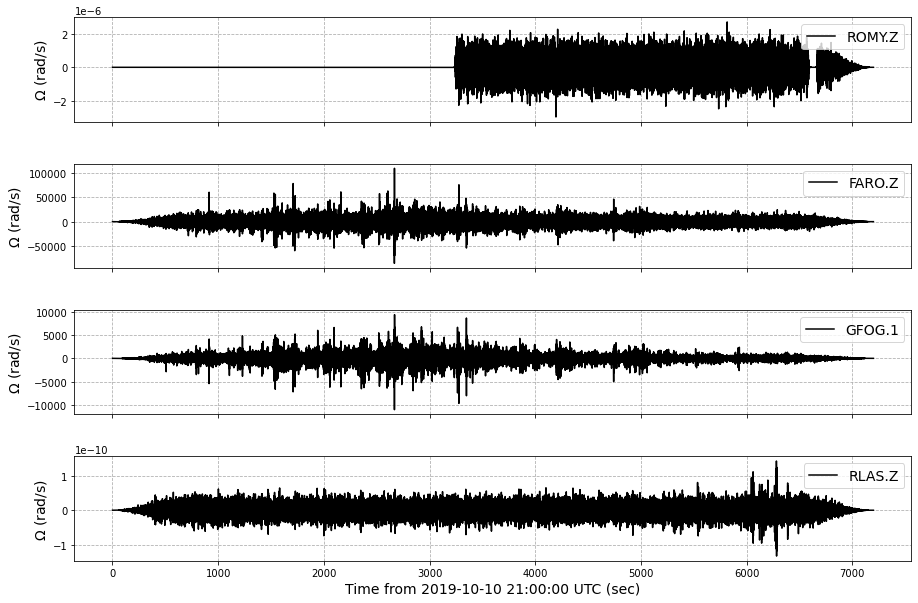

In [19]:
## _____________

fig = __makeplot(st)

if save:
    fig.savefig(path2plots+"plot_dc_offset", 
                dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', format="png",
                transparent=False, bbox_inches="tight", pad_inches=0.2,
               )